In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
authors_df = pd.read_csv('/Users/jinjishen/Desktop/my_new_project/heuritech_analysis/data/MART_AUTHORS.csv')
segmentations_df = pd.read_csv('/Users/jinjishen/Desktop/my_new_project/heuritech_analysis/data/MART_AUTHORS_SEGMENTATIONS.csv')
labels_df = pd.read_csv('/Users/jinjishen/Desktop/my_new_project/heuritech_analysis/data/MART_IMAGES_LABELS.csv')
posts_df = pd.read_csv('/Users/jinjishen/Desktop/my_new_project/heuritech_analysis/data/MART_IMAGES_OF_POSTS.csv')

/var/folders/cr/71y4sg2s6h3_49cpwstkc5zr0000gn/T/ipykernel_53695/2289142473.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts_df = pd.read_csv('/Users/jinjishen/Desktop/my_new_project/heuritech_analysis/data/MART_IMAGES_OF_POSTS.csv')


Number of null values in NB_FOLLOWERS: 1218
Remaining rows after dropping null values: 31623


/var/folders/cr/71y4sg2s6h3_49cpwstkc5zr0000gn/T/ipykernel_53695/3524289866.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentations_df['NB_FOLLOWERS'] = pd.to_numeric(segmentations_df['NB_FOLLOWERS'], errors='coerce')
/var/folders/cr/71y4sg2s6h3_49cpwstkc5zr0000gn/T/ipykernel_53695/3524289866.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentations_df['segment'] = segmentations_df['NB_FOLLOWERS'].apply(get_segment)



=== Segment Statistics ===
           NB_FOLLOWERS                                              
                  count       mean         std      min           max
segment                                                              
Edgy               2388  849641.49  7249907.51  40019.0  2.947181e+08
Mainstream        26681    2041.26     2450.22      0.0  1.199557e+04
Trendy             2554   21126.90     7489.84  12001.0  3.998100e+04

=== Engagement Metrics ===
           NB_LIKES                   COMMENT_COUNT                
               mean median        std          mean median      std
segment                                                            
Edgy        9526.70  419.0  129410.93         96.77   14.0  1059.47
Mainstream    66.72    7.0    2596.57          3.49    0.0   122.60
Trendy       441.46   38.0    6797.56         15.84    4.0    71.99

=== Engagement Rate Statistics ===
              mean  median     std
segment                           
Edgy      

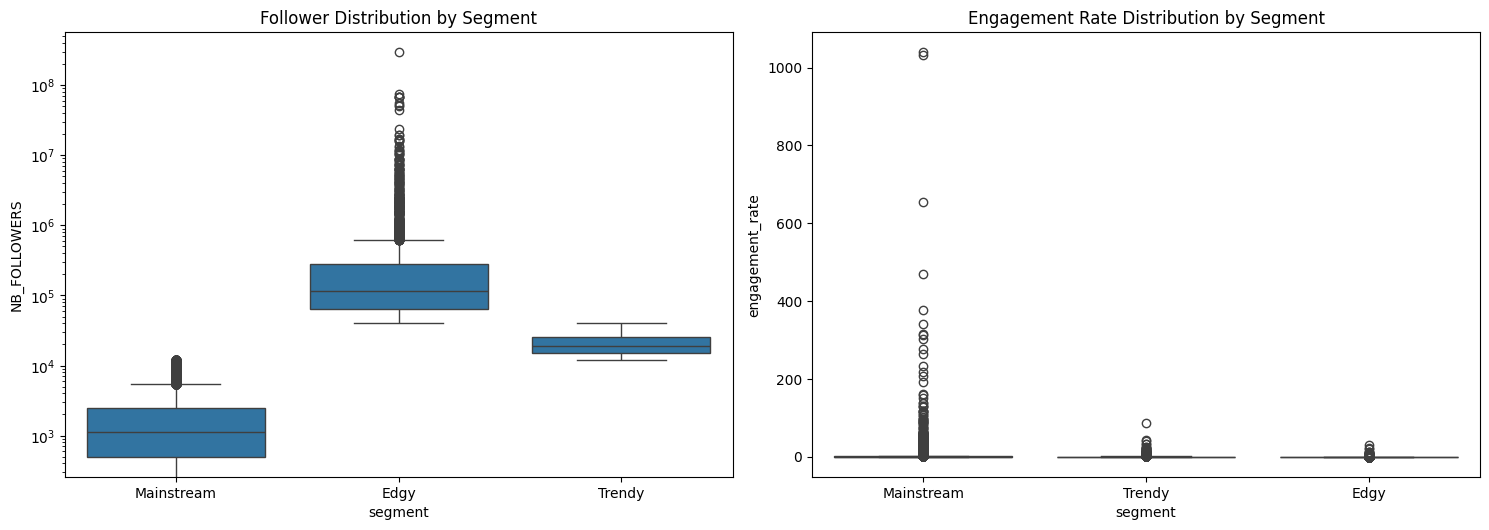

In [7]:
def analyze_current_segmentation(segmentations_df, posts_df, labels_df):
    """
    Comprehensive analysis of current segmentation
    """
    # 1. Count and drop null values in NB_FOLLOWERS
    null_count = segmentations_df['NB_FOLLOWERS'].isnull().sum()
    print(f"Number of null values in NB_FOLLOWERS: {null_count}")
    
    # Drop null values in NB_FOLLOWERS
    segmentations_df = segmentations_df.dropna(subset=['NB_FOLLOWERS'])
    print(f"Remaining rows after dropping null values: {len(segmentations_df)}")
    
    # 2. Follower Distribution Analysis
    def get_segment(followers):
        if followers <= 12000:
            return 'Mainstream'
        elif followers <= 40000:
            return 'Trendy'
        return 'Edgy'
    
    # Ensure NB_FOLLOWERS is numeric
    segmentations_df['NB_FOLLOWERS'] = pd.to_numeric(segmentations_df['NB_FOLLOWERS'], errors='coerce')
    segmentations_df['segment'] = segmentations_df['NB_FOLLOWERS'].apply(get_segment)
    
    # Basic statistics by segment
    segment_stats = segmentations_df.groupby('segment').agg({
        'NB_FOLLOWERS': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    
    # 3. Engagement Analysis
    # Ensure numeric types for engagement metrics
    posts_df['NB_LIKES'] = pd.to_numeric(posts_df['NB_LIKES'], errors='coerce')
    posts_df['COMMENT_COUNT'] = pd.to_numeric(posts_df['COMMENT_COUNT'], errors='coerce')
    
    engagement_metrics = posts_df.merge(
        segmentations_df[['AUTHORID', 'segment']], 
        on='AUTHORID'
    ).groupby('segment').agg({
        'NB_LIKES': ['mean', 'median', 'std'],
        'COMMENT_COUNT': ['mean', 'median', 'std']
    }).round(2)
    
    # 4. Engagement Rate Analysis (likes per follower)
    posts_with_followers = posts_df.merge(
        segmentations_df[['AUTHORID', 'NB_FOLLOWERS', 'segment']], 
        on='AUTHORID'
    )
    
    # Handle division by zero and ensure numeric calculation
    posts_with_followers['engagement_rate'] = np.where(
        posts_with_followers['NB_FOLLOWERS'] > 0,
        posts_with_followers['NB_LIKES'] / posts_with_followers['NB_FOLLOWERS'],
        0
    )
    
    engagement_rate_stats = posts_with_followers.groupby('segment')['engagement_rate'].agg([
        'mean', 'median', 'std'
    ]).round(4)
    
    # 5. Content Analysis (if labels data available)
    if labels_df is not None:
        content_distribution = labels_df.merge(
            posts_df[['IMAGE_ID', 'AUTHORID']], 
            on='IMAGE_ID'
        ).merge(
            segmentations_df[['AUTHORID', 'segment']], 
            on='AUTHORID'
        )
        
        label_distribution = content_distribution.groupby(['segment', 'LABEL_NAME']).size().unstack(fill_value=0)
        # Convert to percentages
        label_distribution = label_distribution.div(label_distribution.sum(axis=1), axis=0)
    else:
        label_distribution = None
    
    # 6. Analysis Results
    analysis_results = {
        'segment_stats': segment_stats,
        'engagement_metrics': engagement_metrics,
        'engagement_rate_stats': engagement_rate_stats,
        'label_distribution': label_distribution
    }
    
    # 7. Visualization
    plt.figure(figsize=(15, 10))
    
    # Follower distribution
    plt.subplot(2, 2, 1)
    sns.boxplot(data=segmentations_df, x='segment', y='NB_FOLLOWERS')
    plt.title('Follower Distribution by Segment')
    plt.yscale('log')
    
    # Engagement rate distribution
    plt.subplot(2, 2, 2)
    sns.boxplot(data=posts_with_followers, x='segment', y='engagement_rate')
    plt.title('Engagement Rate Distribution by Segment')
    
    # Save plots
    plt.tight_layout()
    
    return analysis_results

def calculate_segment_overlap(segmentations_df):
    """
    Analyze potential overlap between segments
    """
    # Ensure numeric type
    segmentations_df['NB_FOLLOWERS'] = pd.to_numeric(segmentations_df['NB_FOLLOWERS'], errors='coerce')
    
    # Calculate distance to segment boundaries
    boundaries = [12000, 40000]
    
    segmentations_df['distance_to_boundary'] = segmentations_df['NB_FOLLOWERS'].apply(
        lambda x: min(abs(x - b) for b in boundaries)
    )
    
    # Identify accounts near boundaries (within 10%)
    boundary_margin = 0.1
    near_boundary = segmentations_df[
        segmentations_df['distance_to_boundary'] <= segmentations_df['NB_FOLLOWERS'] * boundary_margin
    ]
    
    return {
        'total_accounts': len(segmentations_df),
        'accounts_near_boundary': len(near_boundary),
        'percentage_near_boundary': (len(near_boundary) / len(segmentations_df)) * 100
    }

def analyze_temporal_patterns(posts_df, segmentations_df):
    """
    Analyze posting patterns and temporal stability
    """
    # Convert to datetime
    posts_df['post_date'] = pd.to_datetime(posts_df['POST_PUBLICATION_DATE'])
    
    # Merge with author segments
    posts_with_segments = posts_df.merge(
        segmentations_df[['AUTHORID', 'segment']], 
        on='AUTHORID'
    )
    
    # Analyze posting patterns by segment
    posting_patterns = posts_with_segments.groupby(['segment', 
                                                  posts_with_segments['post_date'].dt.hour]
                                                 ).size().unstack(fill_value=0)
    
    # Analyze posting consistency
    posting_consistency = posts_with_segments.groupby('AUTHORID').agg({
        'post_date': lambda x: x.diff().dt.total_seconds().std()  # Standard deviation of time between posts in seconds
    }).merge(segmentations_df[['AUTHORID', 'segment']], on='AUTHORID')
    
    return {
        'posting_patterns': posting_patterns,
        'posting_consistency': posting_consistency.groupby('segment').mean()
    }

def print_analysis_summary(analysis_results, overlap_results, temporal_results):
    """
    Print a summary of all analysis results
    """
    print("\n=== Segment Statistics ===")
    print(analysis_results['segment_stats'])
    
    print("\n=== Engagement Metrics ===")
    print(analysis_results['engagement_metrics'])
    
    print("\n=== Engagement Rate Statistics ===")
    print(analysis_results['engagement_rate_stats'])
    
    if analysis_results['label_distribution'] is not None:
        print("\n=== Label Distribution ===")
        print(analysis_results['label_distribution'])
    
    print("\n=== Segment Overlap Analysis ===")
    print(f"Total accounts: {overlap_results['total_accounts']}")
    print(f"Accounts near boundary: {overlap_results['accounts_near_boundary']}")
    print(f"Percentage near boundary: {overlap_results['percentage_near_boundary']:.2f}%")
    
    print("\n=== Temporal Patterns ===")
    print("Posting Patterns by Hour:")
    print(temporal_results['posting_patterns'])
    print("\nPosting Consistency (std of time between posts in seconds):")
    print(temporal_results['posting_consistency'])

# Run analysis
analysis_results = analyze_current_segmentation(segmentations_df, posts_df, labels_df)
overlap_results = calculate_segment_overlap(segmentations_df)
temporal_results = analyze_temporal_patterns(posts_df, segmentations_df)

# Print summary
print_analysis_summary(analysis_results, overlap_results, temporal_results)